In [1]:
# ===== CELLULE 1 : INSTALLATION ET IMPORTS =====

# Installation des dépendances
!pip install -q datasets pandas matplotlib seaborn scikit-learn openpyxl

# Imports
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import f_oneway, ttest_ind
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

print("✅ Imports terminés")


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ Imports terminés


In [2]:
# ===== CELLULE 2 : CHARGER LE DATASET DEPUIS HUGGING FACE =====

print("📥 Chargement du dataset depuis Hugging Face...")

dataset = load_dataset("cnamuangtoun/resume-job-description-fit")

print("✅ Dataset chargé")
print(f"\n📊 Structure du dataset :")
print(dataset)

# Vérifier les splits disponibles
print(f"\n📂 Splits disponibles : {list(dataset.keys())}")
print(f"   Train : {len(dataset['train']):,} samples")

📥 Chargement du dataset depuis Hugging Face...
✅ Dataset chargé

📊 Structure du dataset :
DatasetDict({
    train: Dataset({
        features: ['resume_text', 'job_description_text', 'label'],
        num_rows: 6241
    })
    test: Dataset({
        features: ['resume_text', 'job_description_text', 'label'],
        num_rows: 1759
    })
})

📂 Splits disponibles : ['train', 'test']
   Train : 6,241 samples


In [3]:
# ===== CELLULE 3 : CONVERTIR EN DATAFRAME PANDAS =====

# Convertir le split 'train' en DataFrame
df = pd.DataFrame(dataset['train'])

print("✅ Dataset converti en DataFrame")
print(f"\n📊 Taille : {len(df):,} lignes × {len(df.columns)} colonnes")
print(f"\n📋 Colonnes : {df.columns.tolist()}")
print(f"\n🔍 Types des colonnes :")
print(df.dtypes)

print(f"\n📝 Aperçu des 3 premières lignes :")
df.head(3)

✅ Dataset converti en DataFrame

📊 Taille : 6,241 lignes × 3 colonnes

📋 Colonnes : ['resume_text', 'job_description_text', 'label']

🔍 Types des colonnes :
resume_text             object
job_description_text    object
label                   object
dtype: object

📝 Aperçu des 3 premières lignes :


,resume_text,job_description_text,label
0,SummaryHighly motivated Sales Associate with e...,Net2Source Inc. is an award-winning total work...,No Fit
1,Professional SummaryCurrently working with Cat...,At Salas OBrien we tell our clients that were ...,No Fit
2,SummaryI started my construction career in Jun...,Schweitzer Engineering Laboratories (SEL) Infr...,No Fit


In [4]:
# ===== CELLULE 4 : ANALYSES EXPLORATOIRES DE BASE =====

print("🔍 ANALYSES EXPLORATOIRES")
print("=" * 70)

# 1. Taille du dataset
print(f"\n📊 Taille du dataset : {len(df):,} samples")

# 2. Valeurs manquantes
print(f"\n❓ Valeurs manquantes par colonne :")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("   ✅ Aucune valeur manquante")
else:
    print(missing[missing > 0])

# 3. Valeurs vides (chaînes vides)
print(f"\n🔍 Valeurs vides (strings vides) :")
for col in ['resume_text', 'job_description_text', 'label']:
    empty_count = (df[col].astype(str).str.strip() == '').sum()
    if empty_count > 0:
        print(f"   ⚠️ {col} : {empty_count} valeurs vides")
    else:
        print(f"   ✅ {col} : Aucune valeur vide")

# 4. Statistiques sur les longueurs de texte
print(f"\n📏 Longueurs des textes (en caractères) :")
df['resume_len'] = df['resume_text'].astype(str).apply(len)
df['job_len'] = df['job_description_text'].astype(str).apply(len)

print(f"\n   Résumés (CV) :")
print(f"      Min    : {df['resume_len'].min():,} caractères")
print(f"      Moyenne: {df['resume_len'].mean():.0f} caractères")
print(f"      Médiane: {df['resume_len'].median():.0f} caractères")
print(f"      Max    : {df['resume_len'].max():,} caractères")

print(f"\n   Offres d'emploi :")
print(f"      Min    : {df['job_len'].min():,} caractères")
print(f"      Moyenne: {df['job_len'].mean():.0f} caractères")
print(f"      Médiane: {df['job_len'].median():.0f} caractères")
print(f"      Max    : {df['job_len'].max():,} caractères")

# 5. Détecter les textes anormalement courts ou longs
print(f"\n⚠️ Détection d'anomalies :")
short_resumes = (df['resume_len'] < 100).sum()
short_jobs = (df['job_len'] < 50).sum()
long_resumes = (df['resume_len'] > 20000).sum()
long_jobs = (df['job_len'] > 10000).sum()

print(f"   CVs trop courts (< 100 chars)      : {short_resumes}")
print(f"   Jobs trop courts (< 50 chars)      : {short_jobs}")
print(f"   CVs trop longs (> 20,000 chars)    : {long_resumes}")
print(f"   Jobs trop longs (> 10,000 chars)   : {long_jobs}")

🔍 ANALYSES EXPLORATOIRES

📊 Taille du dataset : 6,241 samples

❓ Valeurs manquantes par colonne :
   ✅ Aucune valeur manquante

🔍 Valeurs vides (strings vides) :
   ✅ resume_text : Aucune valeur vide
   ✅ job_description_text : Aucune valeur vide
   ✅ label : Aucune valeur vide

📏 Longueurs des textes (en caractères) :

   Résumés (CV) :
      Min    : 897 caractères
      Moyenne: 5804 caractères
      Médiane: 5134 caractères
      Max    : 25,364 caractères

   Offres d'emploi :
      Min    : 72 caractères
      Moyenne: 2731 caractères
      Médiane: 2384 caractères
      Max    : 7,669 caractères

⚠️ Détection d'anomalies :
   CVs trop courts (< 100 chars)      : 0
   Jobs trop courts (< 50 chars)      : 0
   CVs trop longs (> 20,000 chars)    : 7
   Jobs trop longs (> 10,000 chars)   : 0


🎯 ANALYSE DES LABELS

📊 Nombre de labels uniques : 3
   Labels : ['Good Fit', 'No Fit', 'Potential Fit']

📊 Distribution des labels :
   - No Fit               : 3,143 (50.4%)
   - Potential Fit        : 1,556 (24.9%)
   - Good Fit             : 1,542 (24.7%)


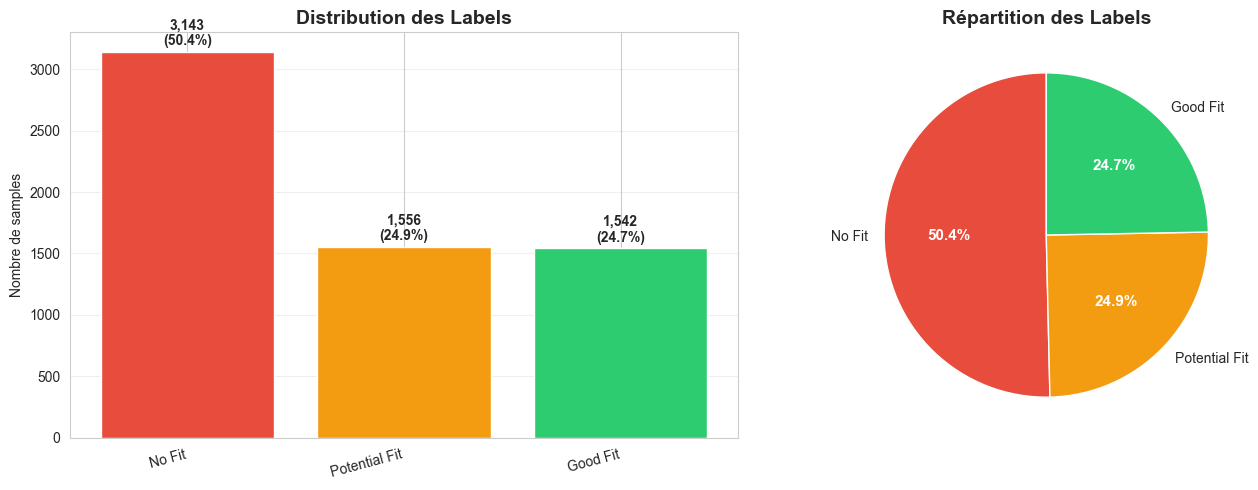


⚖️ Équilibre des classes :
   🟡 Léger déséquilibre (ratio: 2.04)


In [5]:
# ===== CELLULE 5 : ANALYSE DÉTAILLÉE DES LABELS =====

print("🎯 ANALYSE DES LABELS")
print("=" * 70)

# Vérifier les labels uniques
unique_labels = df['label'].unique()
print(f"\n📊 Nombre de labels uniques : {len(unique_labels)}")
print(f"   Labels : {sorted(unique_labels)}")

# Distribution des labels
label_counts = df['label'].value_counts()
print(f"\n📊 Distribution des labels :")
total = len(df)
for label, count in label_counts.items():
    percentage = (count / total) * 100
    print(f"   - {label:20s} : {count:,} ({percentage:.1f}%)")

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1 : Barplot avec pourcentages
ax1 = axes[0]
bars = ax1.bar(range(len(label_counts)), label_counts.values, color=['#2ecc71' if 'Good' in str(label) else '#e74c3c' if 'No' in str(label) else '#f39c12' for label in label_counts.index])
ax1.set_xticks(range(len(label_counts)))
ax1.set_xticklabels(label_counts.index, rotation=15, ha='right')
ax1.set_ylabel('Nombre de samples')
ax1.set_title('Distribution des Labels', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Ajouter les valeurs et pourcentages sur les barres
for i, (count, label) in enumerate(zip(label_counts.values, label_counts.index)):
    percentage = (count / total) * 100
    ax1.text(i, count + 50, f'{count:,}\n({percentage:.1f}%)', 
             ha='center', fontsize=10, fontweight='bold')

# Graphique 2 : Pie chart
ax2 = axes[1]
colors = ['#2ecc71' if 'Good' in str(label) else '#e74c3c' if 'No' in str(label) else '#f39c12' for label in label_counts.index]
wedges, texts, autotexts = ax2.pie(
    label_counts.values, 
    labels=label_counts.index, 
    autopct='%1.1f%%',
    colors=colors,
    startangle=90
)
ax2.set_title('Répartition des Labels', fontsize=14, fontweight='bold')

# Améliorer la lisibilité
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

plt.tight_layout()
plt.show()

# Vérifier l'équilibre des classes
print(f"\n⚖️ Équilibre des classes :")
max_count = label_counts.max()
min_count = label_counts.min()
imbalance_ratio = max_count / min_count

if imbalance_ratio < 1.5:
    print(f"   ✅ Dataset bien équilibré (ratio: {imbalance_ratio:.2f})")
elif imbalance_ratio < 3:
    print(f"   🟡 Léger déséquilibre (ratio: {imbalance_ratio:.2f})")
else:
    print(f"   ⚠️ Déséquilibre important (ratio: {imbalance_ratio:.2f})")
    print(f"   → Nécessite des techniques de rééquilibrage (SMOTE, class_weight)")

📏 DISTRIBUTION DES LONGUEURS DE TEXTE

📊 Statistiques des longueurs :
         resume_len      job_len
count   6241.000000  6241.000000
mean    5804.402980  2731.328313
std     2989.766702  1716.078138
min      897.000000    72.000000
25%     4234.000000  1231.000000
50%     5134.000000  2384.000000
75%     6608.000000  3941.000000
max    25364.000000  7669.000000


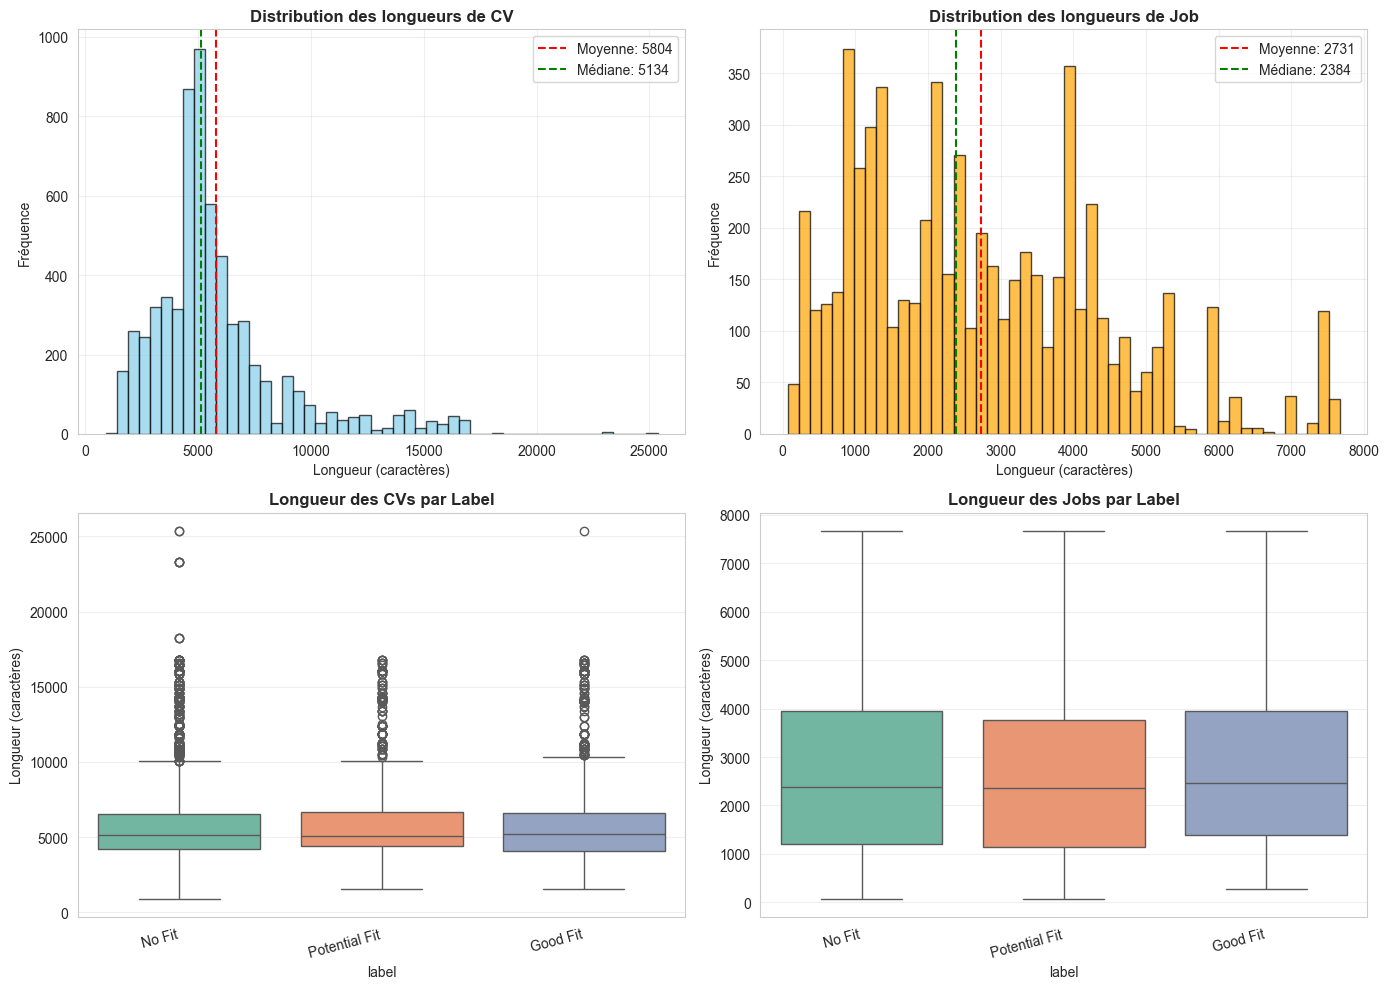


📊 Longueur moyenne par label :
                resume_len      job_len
label                                  
Good Fit       5755.275616  2844.345006
No Fit         5814.328031  2721.084314
Potential Fit  5833.040488  2640.020566


In [6]:
# ===== CELLULE 6 : DISTRIBUTION DES LONGUEURS DE TEXTE =====

print("📏 DISTRIBUTION DES LONGUEURS DE TEXTE")
print("=" * 70)

# Statistiques descriptives
print("\n📊 Statistiques des longueurs :")
print(df[['resume_len', 'job_len']].describe())

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogramme des CVs
axes[0, 0].hist(df['resume_len'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df['resume_len'].mean(), color='red', linestyle='--', 
                   label=f'Moyenne: {df["resume_len"].mean():.0f}')
axes[0, 0].axvline(df['resume_len'].median(), color='green', linestyle='--', 
                   label=f'Médiane: {df["resume_len"].median():.0f}')
axes[0, 0].set_xlabel('Longueur (caractères)')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].set_title('Distribution des longueurs de CV', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Histogramme des Jobs
axes[0, 1].hist(df['job_len'], bins=50, color='orange', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(df['job_len'].mean(), color='red', linestyle='--', 
                   label=f'Moyenne: {df["job_len"].mean():.0f}')
axes[0, 1].axvline(df['job_len'].median(), color='green', linestyle='--', 
                   label=f'Médiane: {df["job_len"].median():.0f}')
axes[0, 1].set_xlabel('Longueur (caractères)')
axes[0, 1].set_ylabel('Fréquence')
axes[0, 1].set_title('Distribution des longueurs de Job', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Boxplot des CVs par label
sns.boxplot(x='label', y='resume_len', data=df, ax=axes[1, 0], palette='Set2')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=15, ha='right')
axes[1, 0].set_title('Longueur des CVs par Label', fontweight='bold')
axes[1, 0].set_ylabel('Longueur (caractères)')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Boxplot des Jobs par label
sns.boxplot(x='label', y='job_len', data=df, ax=axes[1, 1], palette='Set2')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=15, ha='right')
axes[1, 1].set_title('Longueur des Jobs par Label', fontweight='bold')
axes[1, 1].set_ylabel('Longueur (caractères)')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Analyser les différences de longueur par label
print("\n📊 Longueur moyenne par label :")
print(df.groupby('label')[['resume_len', 'job_len']].mean())

In [16]:
# ===== CELLULE 7 : NETTOYAGE DE BASE DES TEXTES =====

print("🧹 NETTOYAGE DES TEXTES")
print("=" * 70)

def basic_clean(text):
    """
    Nettoyage basique d'un texte :
    - Gérer les NaN
    - Supprimer les espaces multiples
    - Supprimer les retours à la ligne excessifs
    - Conserver la ponctuation et la casse
    """
    if pd.isna(text) or text == '':
        return ""
    
    text = str(text)
    
    # Remplacer multiple espaces par un seul
    text = re.sub(r'\s+', ' ', text)
    
    # Supprimer les espaces en début/fin
    text = text.strip()
    
    return text

# Appliquer le nettoyage
print("⏳ Nettoyage en cours...")
df['resume_clean'] = df['resume_text'].apply(basic_clean)
df['job_clean'] = df['job_description_text'].apply(basic_clean)

print("✅ Nettoyage terminé")

# Vérifier l'impact du nettoyage
print(f"\n📊 Impact du nettoyage :")
print(f"   CVs vides après nettoyage    : {(df['resume_clean'] == '').sum()}")
print(f"   Jobs vides après nettoyage   : {(df['job_clean'] == '').sum()}")

# Statistiques après nettoyage
df['resume_clean_len'] = df['resume_clean'].apply(len)
df['job_clean_len'] = df['job_clean'].apply(len)

print(f"\n📏 Longueurs après nettoyage :")
print(f"   CVs  : {df['resume_clean_len'].mean():.0f} chars (avant: {df['resume_len'].mean():.0f})")
print(f"   Jobs : {df['job_clean_len'].mean():.0f} chars (avant: {df['job_len'].mean():.0f})")

# Aperçu d'un exemple nettoyé
print(f"\n📝 Exemple de texte nettoyé (CV) :")
sample_idx = df['resume_clean_len'].idxmax()  # Prendre le plus long
print(f"   Avant ({df.loc[sample_idx, 'resume_len']} chars) : {df.loc[sample_idx, 'resume_text'][:200]}...")
print(f"   Après ({df.loc[sample_idx, 'resume_clean_len']} chars) : {df.loc[sample_idx, 'resume_clean'][:200]}...")

🧹 NETTOYAGE DES TEXTES
⏳ Nettoyage en cours...
✅ Nettoyage terminé

📊 Impact du nettoyage :
   CVs vides après nettoyage    : 0
   Jobs vides après nettoyage   : 0

📏 Longueurs après nettoyage :
   CVs  : 5791 chars (avant: 5804)
   Jobs : 2728 chars (avant: 2731)

📝 Exemple de texte nettoyé (CV) :
   Avant (25364 chars) : SummaryCoordinated Maintenance Electrician at a large flatline plastic company and printed product, that is skilled in repairing, testing, maintaining and installing electrical components. Proficient ...
   Après (25364 chars) : SummaryCoordinated Maintenance Electrician at a large flatline plastic company and printed product, that is skilled in repairing, testing, maintaining and installing electrical components. Proficient ...


🔤 ANALYSE DES MOTS FRÉQUENTS

📊 Top 15 mots dans les CVs :
   and                  : 299,939
   to                   : 110,498
   of                   : 98,457
   the                  : 94,592
   for                  : 71,736
   in                   : 66,923
   with                 : 53,065
   data                 : 47,469
   a                    : 30,705
   on                   : 29,524
   using                : 23,004
   as                   : 21,933
   business             : 19,743
   by                   : 17,645
   test                 : 17,277

📊 Top 15 mots dans les Jobs :
   and                  : 138,326
   to                   : 63,760
   of                   : 53,835
   the                  : 53,392
   in                   : 39,110
   with                 : 38,905
   a                    : 38,572
   for                  : 26,925
   or                   : 20,111
   is                   : 16,720
   experience           : 15,403
   data                 : 15,214
   as           

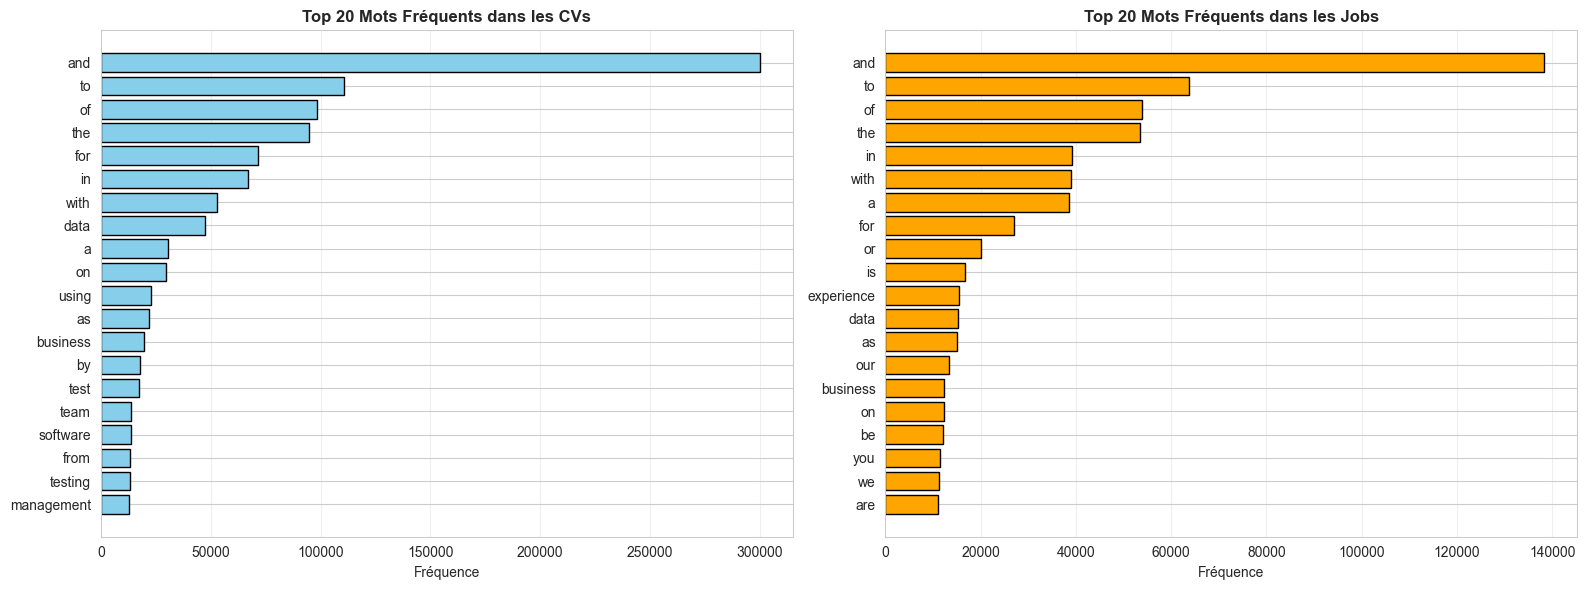


🔗 Mots communs dans le top 100 (CVs et Jobs) : 17
   Exemples : that, the, by, in, on, a, experience, for, with, software, and, to, as, of, team


In [17]:
# ===== CELLULE 8 : ANALYSE DES MOTS FRÉQUENTS =====

print("🔤 ANALYSE DES MOTS FRÉQUENTS")
print("=" * 70)

# Extraire tous les mots (en minuscules)
all_resume_words = " ".join(df['resume_clean'].fillna('')).lower().split()
all_job_words = " ".join(df['job_clean'].fillna('')).lower().split()

# Compter les occurrences
resume_word_counts = Counter(all_resume_words)
job_word_counts = Counter(all_job_words)

# Top 30 mots
top_resume_words = resume_word_counts.most_common(30)
top_job_words = job_word_counts.most_common(30)

print(f"\n📊 Top 15 mots dans les CVs :")
for word, count in top_resume_words[:15]:
    print(f"   {word:20s} : {count:,}")

print(f"\n📊 Top 15 mots dans les Jobs :")
for word, count in top_job_words[:15]:
    print(f"   {word:20s} : {count:,}")

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top mots CVs
words_resume, counts_resume = zip(*top_resume_words[:20])
axes[0].barh(range(len(words_resume)), counts_resume, color='skyblue', edgecolor='black')
axes[0].set_yticks(range(len(words_resume)))
axes[0].set_yticklabels(words_resume)
axes[0].invert_yaxis()
axes[0].set_xlabel('Fréquence')
axes[0].set_title('Top 20 Mots Fréquents dans les CVs', fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Top mots Jobs
words_job, counts_job = zip(*top_job_words[:20])
axes[1].barh(range(len(words_job)), counts_job, color='orange', edgecolor='black')
axes[1].set_yticks(range(len(words_job)))
axes[1].set_yticklabels(words_job)
axes[1].invert_yaxis()
axes[1].set_xlabel('Fréquence')
axes[1].set_title('Top 20 Mots Fréquents dans les Jobs', fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Mots communs entre CVs et Jobs
resume_words_set = set(dict(top_resume_words[:100]).keys())
job_words_set = set(dict(top_job_words[:100]).keys())
common_words = resume_words_set.intersection(job_words_set)

print(f"\n🔗 Mots communs dans le top 100 (CVs et Jobs) : {len(common_words)}")
print(f"   Exemples : {', '.join(list(common_words)[:15])}")

🔍 CALCUL DE LA SIMILARITÉ TF-IDF
⏳ Calcul des vecteurs TF-IDF...
✅ Matrices TF-IDF créées
   Vocabulaire : 5,000 termes
   Shape CVs   : (6241, 5000)
   Shape Jobs  : (6241, 5000)

⏳ Calcul des similarités cosinus...
✅ Similarités calculées

📊 Statistiques de similarité TF-IDF :
count    6241.000000
mean        0.091702
std         0.060453
min         0.000000
25%         0.048798
50%         0.077575
75%         0.118187
max         0.399784
Name: tfidf_similarity, dtype: float64


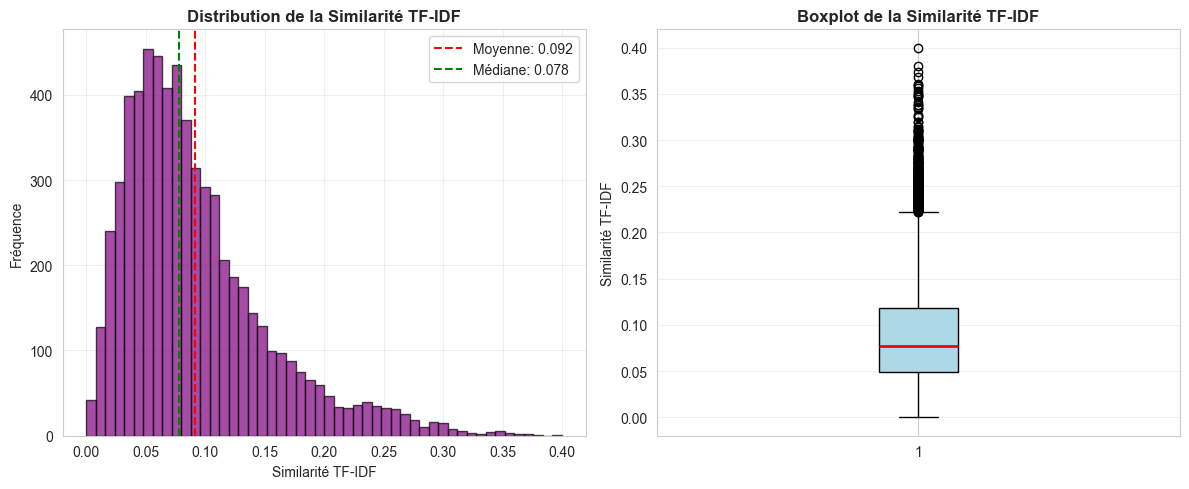

In [18]:
# ===== CELLULE 9 : CALCUL DE LA SIMILARITÉ TF-IDF =====

print("🔍 CALCUL DE LA SIMILARITÉ TF-IDF")
print("=" * 70)

# Initialiser TF-IDF Vectorizer
print("⏳ Calcul des vecteurs TF-IDF...")
tfidf = TfidfVectorizer(
    max_features=5000,  # Limiter à 5000 features les plus importantes
    stop_words='english',  # Retirer les stop words anglais
    ngram_range=(1, 2),  # Unigrammes et bigrammes
    min_df=2  # Ignorer les mots qui apparaissent dans moins de 2 documents
)

# Créer les matrices TF-IDF
resume_tfidf = tfidf.fit_transform(df['resume_clean'].fillna(''))
job_tfidf = tfidf.transform(df['job_clean'].fillna(''))

print(f"✅ Matrices TF-IDF créées")
print(f"   Vocabulaire : {len(tfidf.vocabulary_):,} termes")
print(f"   Shape CVs   : {resume_tfidf.shape}")
print(f"   Shape Jobs  : {job_tfidf.shape}")

# Calculer la similarité cosinus pour chaque paire (CV, Job)
print(f"\n⏳ Calcul des similarités cosinus...")
similarities = []
for i in range(len(df)):
    sim = cosine_similarity(resume_tfidf[i], job_tfidf[i])[0][0]
    similarities.append(sim)

df['tfidf_similarity'] = similarities

print(f"✅ Similarités calculées")

# Statistiques globales
print(f"\n📊 Statistiques de similarité TF-IDF :")
print(df['tfidf_similarity'].describe())

# Visualisation de la distribution
plt.figure(figsize=(12, 5))

# Histogramme
plt.subplot(1, 2, 1)
plt.hist(df['tfidf_similarity'], bins=50, color='purple', edgecolor='black', alpha=0.7)
plt.axvline(df['tfidf_similarity'].mean(), color='red', linestyle='--', 
            label=f'Moyenne: {df["tfidf_similarity"].mean():.3f}')
plt.axvline(df['tfidf_similarity'].median(), color='green', linestyle='--', 
            label=f'Médiane: {df["tfidf_similarity"].median():.3f}')
plt.xlabel('Similarité TF-IDF')
plt.ylabel('Fréquence')
plt.title('Distribution de la Similarité TF-IDF', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# Boxplot
plt.subplot(1, 2, 2)
plt.boxplot(df['tfidf_similarity'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            medianprops=dict(color='red', linewidth=2))
plt.ylabel('Similarité TF-IDF')
plt.title('Boxplot de la Similarité TF-IDF', fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

📊 SIMILARITÉ TF-IDF PAR LABEL

📊 Similarité TF-IDF par label :
                count      mean       std       min       25%       50%  \
label                                                                     
Good Fit       1542.0  0.112473  0.064467  0.001553  0.065097  0.099180   
No Fit         3143.0  0.076972  0.052607  0.000000  0.041123  0.064512   
Potential Fit  1556.0  0.100870  0.063279  0.000000  0.055038  0.087820   

                    75%       max  
label                              
Good Fit       0.146338  0.399784  
No Fit         0.097224  0.380623  
Potential Fit  0.130960  0.373522  


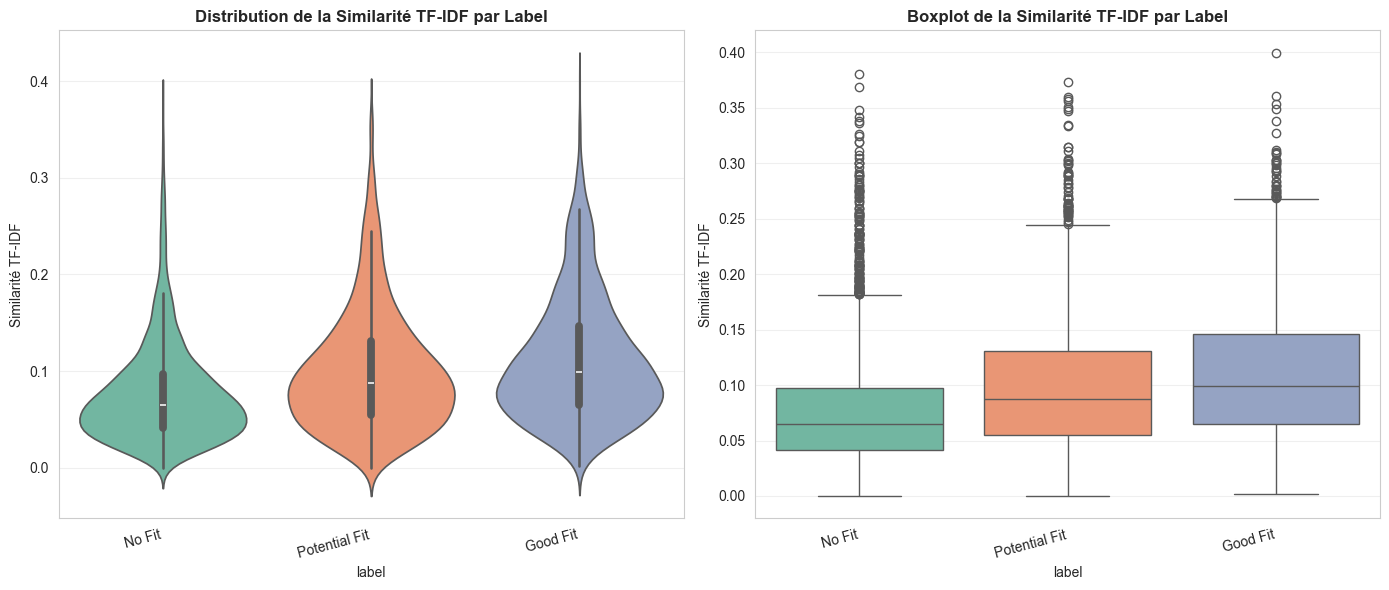


🧪 Test ANOVA (comparaison globale des 3 groupes)
   F-statistic : 216.160
   p-value     : 0.000000
   ✅ Différence TRÈS SIGNIFICATIVE entre les groupes (p < 0.001)

🔍 Comparaisons par paires (T-tests) :
   No Fit               vs Good Fit            
      Différence de moyenne : -0.0355
      p-value : 0.000000  ✅ SIGNIFICATIF
   Potential Fit        vs Good Fit            
      Différence de moyenne : -0.0116
      p-value : 0.000000  ✅ SIGNIFICATIF
   Potential Fit        vs No Fit              
      Différence de moyenne : +0.0239
      p-value : 0.000000  ✅ SIGNIFICATIF

💡 INTERPRÉTATION :
   Good Fit      : 0.1125
   Potential Fit : 0.1009
   No Fit        : 0.0770

   ✅ 'Good Fit' a une similarité +0.0355 plus élevée que 'No Fit'
   → Le JobMatcher devrait bien discriminer les bons/mauvais matchs


In [19]:
# ===== CELLULE 10 : SIMILARITÉ TF-IDF PAR LABEL =====

print("📊 SIMILARITÉ TF-IDF PAR LABEL")
print("=" * 70)

# Statistiques par label
print("\n📊 Similarité TF-IDF par label :")
similarity_by_label = df.groupby('label')['tfidf_similarity'].describe()
print(similarity_by_label)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Violin plot
sns.violinplot(x='label', y='tfidf_similarity', data=df, ax=axes[0], palette='Set2')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=15, ha='right')
axes[0].set_title('Distribution de la Similarité TF-IDF par Label', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Similarité TF-IDF')
axes[0].grid(axis='y', alpha=0.3)

# 2. Boxplot
sns.boxplot(x='label', y='tfidf_similarity', data=df, ax=axes[1], palette='Set2')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=15, ha='right')
axes[1].set_title('Boxplot de la Similarité TF-IDF par Label', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Similarité TF-IDF')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Test statistique ANOVA (pour 3+ groupes)
print("\n🧪 Test ANOVA (comparaison globale des 3 groupes)")
labels = sorted(df['label'].unique())
groups = [df[df['label'] == label]['tfidf_similarity'].values for label in labels]

f_stat, p_value = f_oneway(*groups)

print(f"   F-statistic : {f_stat:.3f}")
print(f"   p-value     : {p_value:.6f}")

if p_value < 0.001:
    print("   ✅ Différence TRÈS SIGNIFICATIVE entre les groupes (p < 0.001)")
elif p_value < 0.05:
    print("   ✅ Différence SIGNIFICATIVE entre les groupes (p < 0.05)")
else:
    print("   ❌ Pas de différence significative (p >= 0.05)")

# Comparaisons par paires (T-tests post-hoc)
print(f"\n🔍 Comparaisons par paires (T-tests) :")

for i in range(len(labels)):
    for j in range(i + 1, len(labels)):
        label1, label2 = labels[i], labels[j]
        
        group1 = df[df['label'] == label1]['tfidf_similarity']
        group2 = df[df['label'] == label2]['tfidf_similarity']
        
        t_stat, p_val = ttest_ind(group1, group2)
        mean_diff = group2.mean() - group1.mean()
        
        significance = "✅ SIGNIFICATIF" if p_val < 0.05 else "❌ Non significatif"
        
        print(f"   {label2:20s} vs {label1:20s}")
        print(f"      Différence de moyenne : {mean_diff:+.4f}")
        print(f"      p-value : {p_val:.6f}  {significance}")

# Interpréter les résultats
print(f"\n💡 INTERPRÉTATION :")

good_fit_sim = df[df['label'] == 'Good Fit']['tfidf_similarity'].mean()
no_fit_sim = df[df['label'] == 'No Fit']['tfidf_similarity'].mean()
potential_fit_sim = df[df['label'] == 'Potential Fit']['tfidf_similarity'].mean()

print(f"   Good Fit      : {good_fit_sim:.4f}")
print(f"   Potential Fit : {potential_fit_sim:.4f}")
print(f"   No Fit        : {no_fit_sim:.4f}")

diff_good_no = good_fit_sim - no_fit_sim

if diff_good_no > 0.03:
    print(f"\n   ✅ 'Good Fit' a une similarité {diff_good_no:+.4f} plus élevée que 'No Fit'")
    print(f"   → Le JobMatcher devrait bien discriminer les bons/mauvais matchs")
elif diff_good_no > 0.01:
    print(f"\n   🟡 'Good Fit' a une similarité légèrement plus élevée ({diff_good_no:+.4f})")
    print(f"   → La discrimination sera modérée")
else:
    print(f"\n   ⚠️ Faible différence ({diff_good_no:+.4f}) entre Good Fit et No Fit")
    print(f"   → La qualité des labels pourrait être problématique")

In [20]:
# ===== CELLULE 11 : INSPECTION D'EXEMPLES PAR LABEL =====

print("🔍 INSPECTION D'EXEMPLES PAR LABEL")
print("=" * 70)

# Fonction pour afficher un exemple
def display_sample(row):
    print(f"\n{'='*70}")
    print(f"Label : {row['label']}")
    print(f"Similarité TF-IDF : {row['tfidf_similarity']:.4f}")
    print(f"\n📄 CV (500 premiers caractères) :")
    print(row['resume_clean'][:500] + "...")
    print(f"\n💼 Job (500 premiers caractères) :")
    print(row['job_clean'][:500] + "...")
    print(f"{'='*70}")

# Afficher 1 exemple par label (choisi aléatoirement)
print("\n🎲 Exemples aléatoires par label :\n")

for label in sorted(df['label'].unique()):
    sample = df[df['label'] == label].sample(n=1, random_state=42).iloc[0]
    display_sample(sample)

# Cas extrêmes
print("\n\n🔥 CAS EXTRÊMES :\n")

# Highest similarity
print("=" * 70)
print("🏆 PLUS HAUTE SIMILARITÉ TF-IDF")
highest_sim_idx = df['tfidf_similarity'].idxmax()
display_sample(df.loc[highest_sim_idx])

# Lowest similarity
print("\n" + "=" * 70)
print("⚠️ PLUS BASSE SIMILARITÉ TF-IDF")
lowest_sim_idx = df['tfidf_similarity'].idxmin()
display_sample(df.loc[lowest_sim_idx])

# Good Fit avec faible similarité (incohérent)
good_fit_low_sim = df[(df['label'] == 'Good Fit') & (df['tfidf_similarity'] < 0.1)]
if len(good_fit_low_sim) > 0:
    print("\n" + "=" * 70)
    print("🤔 'GOOD FIT' AVEC FAIBLE SIMILARITÉ (INCOHÉRENT)")
    display_sample(good_fit_low_sim.sample(n=1, random_state=42).iloc[0])
    print(f"\n⚠️ Trouvé {len(good_fit_low_sim)} 'Good Fit' avec similarité < 0.1")

# No Fit avec haute similarité (incohérent)
no_fit_high_sim = df[(df['label'] == 'No Fit') & (df['tfidf_similarity'] > 0.3)]
if len(no_fit_high_sim) > 0:
    print("\n" + "=" * 70)
    print("🤔 'NO FIT' AVEC HAUTE SIMILARITÉ (INCOHÉRENT)")
    display_sample(no_fit_high_sim.sample(n=1, random_state=42).iloc[0])
    print(f"\n⚠️ Trouvé {len(no_fit_high_sim)} 'No Fit' avec similarité > 0.3")

🔍 INSPECTION D'EXEMPLES PAR LABEL

🎲 Exemples aléatoires par label :


Label : Good Fit
Similarité TF-IDF : 0.1983

📄 CV (500 premiers caractères) :
ProfileSecure a position with a well-established organization with a stable environment that will lead to a lasting in the field of Electrical Engineering.I want to gain experience and to be a part of a dynamic team. I want to apply all that I have learned through experience and academics in engineering and put to use what I have learned.PROFESSIONAL SNAPSHOTSA budding professional with 1+ years in the field of Operation maintenance, plant reactive, preventive and predictive maintenance, Report ...

💼 Job (500 premiers caractères) :
Hello, please look into the below mentioned role if you are comfortable kindly reply me back with your updated resume . Role: Electrical Engineer Location: Mare Island, CAContract Responsibilities and Accountabilities Perform and generate reports on all routine tests and testing activities. Troubleshoot manufac

In [21]:
# ===== CELLULE 12 : SAUVEGARDER LE DATASET NETTOYÉ =====

print("💾 SAUVEGARDE DU DATASET NETTOYÉ")
print("=" * 70)

# Créer le dossier data s'il n'existe pas
output_path_csv = Path('../data/huggingface_resume_job_fit.csv')
output_path_excel = Path('../data/huggingface_resume_job_fit.xlsx')
output_path_csv.parent.mkdir(parents=True, exist_ok=True)

# Sélectionner les colonnes finales
df_final = df[['resume_text', 'job_description_text', 'label', 'tfidf_similarity']].copy()

# Renommer pour simplifier
df_final = df_final.rename(columns={
    'resume_text': 'resume',
    'job_description_text': 'job_description'
})

# Supprimer les lignes avec des textes vides
initial_size = len(df_final)
df_final = df_final[
    (df_final['resume'].str.len() > 50) & 
    (df_final['job_description'].str.len() > 50)
]
dropped = initial_size - len(df_final)

print(f"\n📊 Nettoyage final :")
print(f"   Taille initiale           : {initial_size:,} samples")
print(f"   Textes trop courts retirés: {dropped:,}")
print(f"   Taille finale             : {len(df_final):,} samples")

# Convertir les labels en scores numériques
print(f"\n🔄 Conversion des labels en scores numériques...")

label_to_score = {
    'No Fit': 0.0,
    'Potential Fit': 0.5,
    'Good Fit': 1.0
}

df_final['score_target'] = df_final['label'].map(label_to_score)

# Vérifier les conversions
print(f"\n📊 Mapping appliqué :")
for label, score in sorted(label_to_score.items(), key=lambda x: x[1]):
    count = (df_final['label'] == label).sum()
    percentage = (count / len(df_final)) * 100
    print(f"   '{label:20s}' → {score:.1f} : {count:,} samples ({percentage:.1f}%)")

# Vérifier les NaN
if df_final['score_target'].isnull().sum() > 0:
    print(f"\n⚠️ ATTENTION : {df_final['score_target'].isnull().sum()} labels non mappés !")
    problematic = df_final[df_final['score_target'].isnull()]['label'].unique()
    print(f"   Labels problématiques : {problematic}")
    df_final = df_final.dropna(subset=['score_target'])
else:
    print(f"\n✅ Tous les labels convertis avec succès")

# Statistiques finales
print(f"\n🎯 Distribution finale des scores :")
print(df_final['score_target'].value_counts().sort_index())
print(f"\n   Score moyen  : {df_final['score_target'].mean():.3f}")
print(f"   Score médian : {df_final['score_target'].median():.3f}")

# Sauvegarder en CSV (pour le script Python)
df_final.to_csv(output_path_csv, index=False)

# Sauvegarder en EXCEL (pour inspection manuelle)
df_final.to_excel(output_path_excel, index=False, engine='openpyxl')

print(f"\n✅ Dataset sauvegardé en 2 formats :")
print(f"   📄 CSV   : {output_path_csv} ({output_path_csv.stat().st_size / 1024 / 1024:.2f} MB)")
print(f"   📊 EXCEL : {output_path_excel} ({output_path_excel.stat().st_size / 1024 / 1024:.2f} MB)")
print(f"\n   Colonnes : {df_final.columns.tolist()}")

print(f"\n🎯 Prochaines étapes :")
print(f"   1. Inspecter le fichier Excel pour vérifier la qualité")
print(f"   2. Lancer : python src/compute_features_from_huggingface.py")

💾 SAUVEGARDE DU DATASET NETTOYÉ

📊 Nettoyage final :
   Taille initiale           : 6,241 samples
   Textes trop courts retirés: 0
   Taille finale             : 6,241 samples

🔄 Conversion des labels en scores numériques...

📊 Mapping appliqué :
   'No Fit              ' → 0.0 : 3,143 samples (50.4%)
   'Potential Fit       ' → 0.5 : 1,556 samples (24.9%)
   'Good Fit            ' → 1.0 : 1,542 samples (24.7%)

✅ Tous les labels convertis avec succès

🎯 Distribution finale des scores :
score_target
0.0    3143
0.5    1556
1.0    1542
Name: count, dtype: int64

   Score moyen  : 0.372
   Score médian : 0.000

✅ Dataset sauvegardé en 2 formats :
   📄 CSV   : ..\data\huggingface_resume_job_fit.csv (51.11 MB)
   📊 EXCEL : ..\data\huggingface_resume_job_fit.xlsx (17.49 MB)

   Colonnes : ['resume', 'job_description', 'label', 'tfidf_similarity', 'score_target']

🎯 Prochaines étapes :
   1. Inspecter le fichier Excel pour vérifier la qualité
   2. Lancer : python src/compute_features_from_h